##### <b>Step-1: Importing Libraries</b>

In [ ]:
import os
import cv2
import time
import numpy as np
import tensorflow as tf
from PIL import Image
import numpy as np

import tensorflow as tf
from tensorflow import keras
from skimage import transform
from google.colab import drive
from keras import backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,Conv2DTranspose,MaxPool2D,Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##### <b>Step-2: Mounting Drive</b>

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/skin_data"

In [ ]:
train_images_path=os.path.join(path,"train_data")
train_mask_path=os.path.join(path,"train_label")

In [ ]:
len(os.listdir(train_images_path))

900

In [ ]:
import os
import cv2
import numpy as np
from random import shuffle
def read_data(images_path, masks_path):
    images = []
    masks = []
    i = 0

    for subdir, dirs, files in os.walk(images_path):
        for file in files:
            mask_file = os.path.splitext(file)[0]
            mask_file=mask_file+'.png'

            image = cv2.imread(os.path.join(images_path, file))
            mask = cv2.imread(os.path.join(masks_path, mask_file))

            # Resize the image and mask
            image = cv2.resize(image, (224,224))
            mask = cv2.resize(mask, (224,224))

            # Convert the mask to grayscale
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

            # Expand the dimensions of the mask
            mask = np.expand_dims(mask, axis=-1)

            # Apply image augmentations
            images.append(image/255.0)
            masks.append(mask/255.0)
            if i%50==0:
              print(i)
            i=i+1

    # Shuffle the images and masks
    combined = list(zip(images, masks))
    shuffle(combined)
    images, masks = zip(*combined)
    images = np.array(images)
    masks = np.array(masks)

    return images, masks


In [ ]:
train_images,train_masks=read_data(train_images_path,train_mask_path)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validate)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

print("Train Images Shape:", train_images.shape)
print("Train Masks Shape:", train_masks.shape)
print("Validation Images Shape:", val_images.shape)
print("Validation Masks Shape:", val_masks.shape)


Train Images Shape: (720, 224, 224, 3)
Train Masks Shape: (720, 224, 224, 1)
Validation Images Shape: (180, 224, 224, 3)
Validation Masks Shape: (180, 224, 224, 1)


In [ ]:
image_size=224

In [ ]:
import tensorflow as tf

def f1_score(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    actual_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())

    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1

def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


In [ ]:
!pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
import segmentation_models as sm
# Compile the model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


# binary segmentation (these parameters are default when you call Unet('resnet34')
model = sm.Unet('resnet34',input_shape=(224,224,3),encoder_weights="imagenet", classes=1, activation='sigmoid')
preprocess_input = sm.get_preprocessing('resnet34')
train_images = preprocess_input(train_images)
val_images = preprocess_input(val_images)

# Define the optimizer
optimizer = Adam(lr=0.0001)
model.compile(
    optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", sm.metrics.iou_score, dice_coefficient,f1_score],
)

lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6)
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 224, 224, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, 230, 230, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

# Model Compilation

In [ ]:
history = model.fit(train_images,train_masks,
                          batch_size=4,epochs=20,verbose = 1,validation_data=(val_images,val_masks)
                          )

Epoch 1/20
180/180 [==============================] - 50s 86ms/step - loss: 0.2923 - accuracy: 0.8841 - iou_score: 0.5091 - dice_coefficient: 0.6669 - f1_score: 0.7783 - val_loss: 0.6231 - val_accuracy: 0.7305 - val_iou_score: 0.1025 - val_dice_coefficient: 0.1856 - val_f1_score: 0.0000e+00
Epoch 2/20
180/180 [==============================] - 14s 78ms/step - loss: 0.2110 - accuracy: 0.9157 - iou_score: 0.6160 - dice_coefficient: 0.7581 - f1_score: 0.8387 - val_loss: 1.6493 - val_accuracy: 0.7305 - val_iou_score: 0.0022 - val_dice_coefficient: 0.0044 - val_f1_score: 0.0000e+00
Epoch 3/20
180/180 [==============================] - 15s 81ms/step - loss: 0.1766 - accuracy: 0.9290 - iou_score: 0.6711 - dice_coefficient: 0.7993 - f1_score: 0.8655 - val_loss: 0.6920 - val_accuracy: 0.6920 - val_iou_score: 0.2735 - val_dice_coefficient: 0.4256 - val_f1_score: 0.4600
Epoch 4/20
180/180 [==============================] - 15s 81ms/step - loss: 0.1730 - accuracy: 0.9294 - iou_score: 0.6794 - dice

6/6 [==============================] - 6s 466ms/step


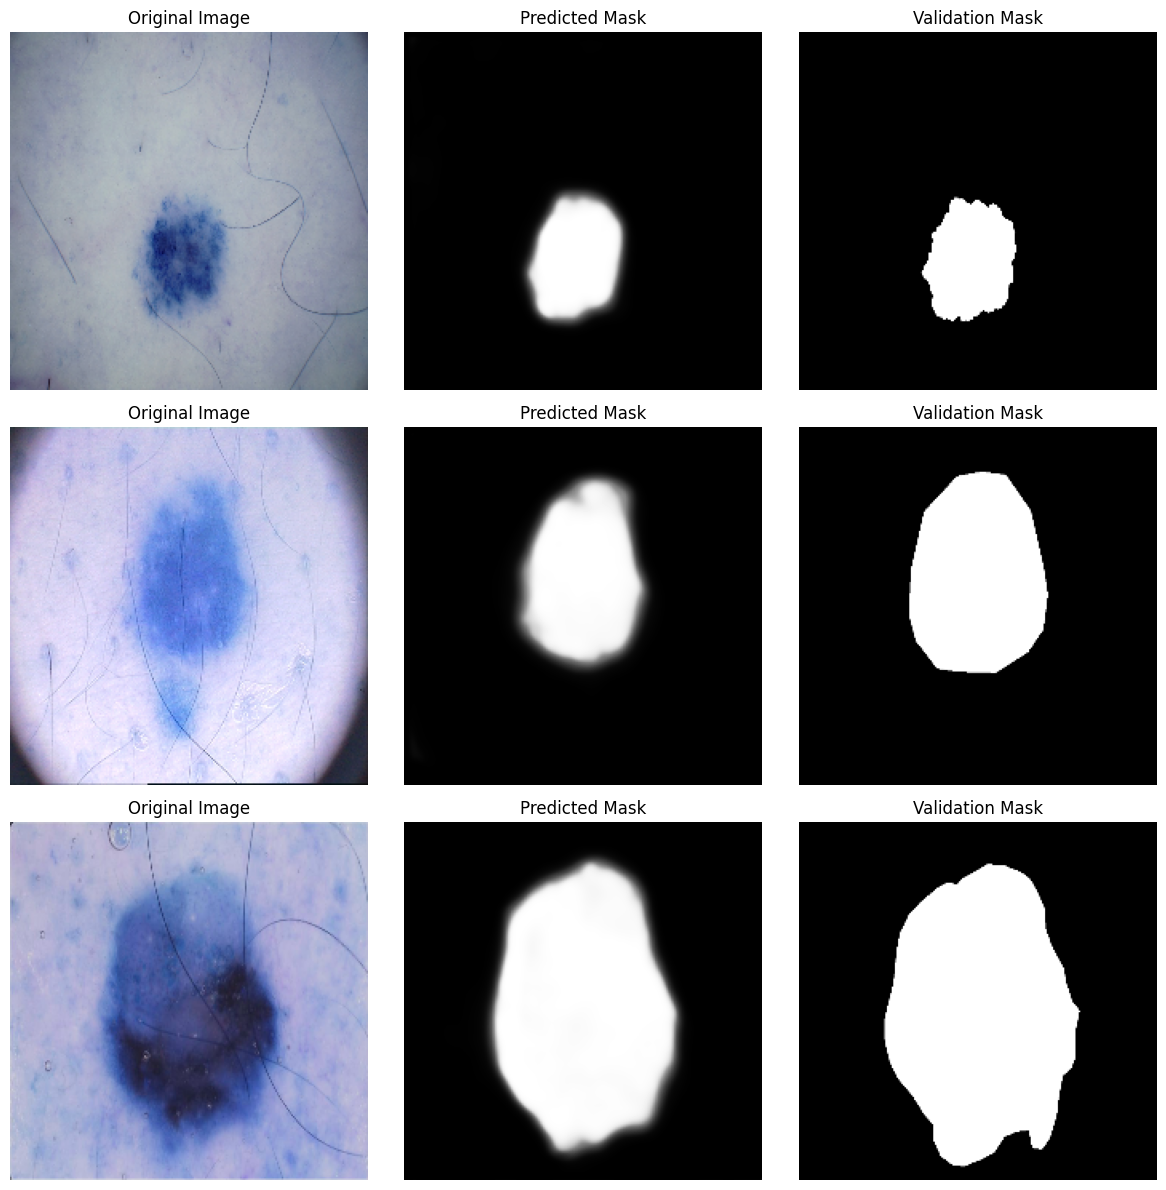

In [ ]:
import matplotlib.pyplot as plt
import math

# Predict the masks for validation images
pred_masks = model.predict(val_images)

# Define the number of rows and columns for displaying the images
num_images = 3

# Select random indices for displaying the images
indices = np.random.choice(len(val_images), size=num_images, replace=False)

# Create subplots for displaying the images
fig, axes = plt.subplots(num_images, 3, figsize=(12, 12))

# Iterate over the selected indices and display the images
for i, index in enumerate(indices):
    # Display the original image
    axes[i, 0].imshow(val_images[index])
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Display the predicted mask
    axes[i, 1].imshow(pred_masks[index], cmap='gray')
    axes[i, 1].set_title('Predicted Mask')
    axes[i, 1].axis('off')

    # Display the validation mask
    axes[i, 2].imshow(val_masks[index], cmap='gray')
    axes[i, 2].set_title('Validation Mask')
    axes[i, 2].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


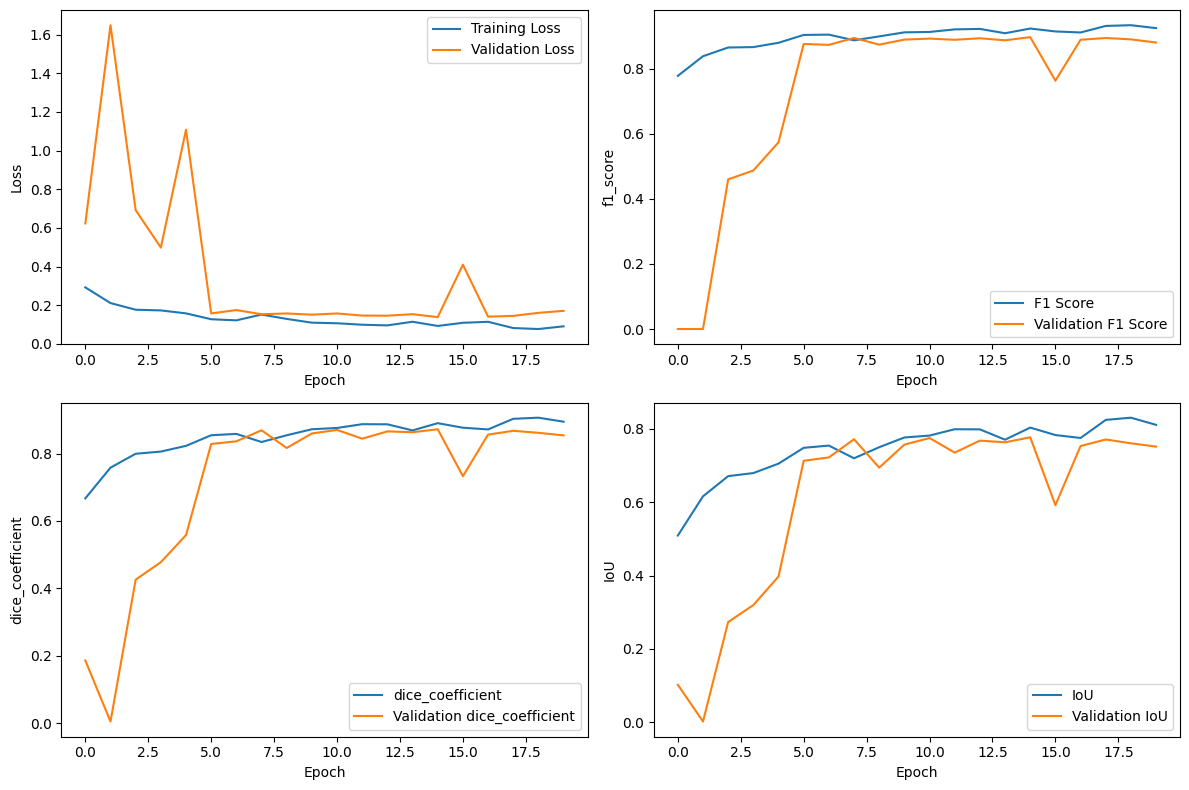

In [ ]:
import matplotlib.pyplot as plt

# Plot metrics
plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# F1 Score
plt.subplot(2, 2, 2)
plt.plot(history.history['f1_score'], label='F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('f1_score')
plt.legend()

# dice_coefficient
plt.subplot(2, 2, 3)
plt.plot(history.history['dice_coefficient'], label='dice_coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation dice_coefficient')
plt.xlabel('Epoch')
plt.ylabel('dice_coefficient')
plt.legend()

# IoU
plt.subplot(2, 2, 4)
plt.plot(history.history['iou_score'], label='IoU')
plt.plot(history.history['val_iou_score'], label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/skin_data/unet(resnet).h5")